In [2]:
import torch
torch.manual_seed(10)

In [2]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

y.backward(retain_graph=True)   # 实际调用torch.autograd.backward，如果想要再次使用计算图将retain_graph设置为True
print(w.grad)
# y.backward()

tensor([5.])


In [3]:
# grad_tensors用于多个梯度之间权重的设置
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)     # retain_grad()
b = torch.add(w, 1)

y0 = torch.mul(a, b)    # y0 = (x+w) * (w+1)
y1 = torch.add(a, b)    # y1 = (x+w) + (w+1)    dy1/dw = 2

loss = torch.cat([y0, y1], dim=0)       # [y0, y1]
grad_tensors = torch.tensor([1., 2.])   # 多梯度权重

loss.backward(gradient=grad_tensors)    # gradient 传入 torch.autograd.backward()中的grad_tensors

print(w.grad)

tensor([9.])


In [13]:
x = torch.tensor([3.], requires_grad=True)
y = torch.pow(x, 2)     # y = x**2

# 一阶导数
# grad_1 = dy/dx = 2x = 2 * 3 = 6，create_graph创建导数的计算图，为二阶求导保留计算图
grad_1 = torch.autograd.grad(y, x, create_graph=True)   
print(grad_1)

# 二阶导数
# grad_2 = d(dy/dx)/dx = d(2x)/dx = 2
grad_2 = torch.autograd.grad(grad_1[0], x)   

print(grad_2)

(tensor([6.], grad_fn=<MulBackward0>),)
(tensor([2.]),)


## autograd小贴士
### 1、梯度不自动清零，需要手动清零grad.zero_()
### 2、依赖于叶子结点的结点requires_grad默认为True
### 3、叶子结点不可执行in-place

In [3]:
# 小贴士一
# 如果有多次计算梯度，则会出现梯度叠加，每个计算梯度之后需对其清零
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

for i in range(4):   # 梯度不清零，叠加
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)

    y.backward()
    print(w.grad)

    w.grad.zero_()   # 下划线原地（原位）操作，梯度清零

tensor([5.])
tensor([5.])
tensor([5.])
tensor([5.])


In [14]:
# 小贴士二
# 依赖于叶子结点的结点requires_grad默认为True
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

print(a.requires_grad, b.requires_grad, y.requires_grad)

True True True


In [15]:
# in-place操作就是在原始内存中改变数据
a = torch.ones((1, ))
print(id(a), a)

# a = a + torch.ones((1, ))
# print(id(a), a)

# +=为原地操作
a += torch.ones((1, ))
print(id(a), a)

3060211489352 tensor([1.])
3060211489352 tensor([2.])


In [ ]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

# 前向传播中叶子结点的内容，在后向传播的过程中需要使用，使用原地操作会使得原本地址中的数据改变而无法完成原本的计算
w.add_(1)   # 此处错了
"""
autograd小贴士：
    梯度不自动清零 
    依赖于叶子结点的结点，requires_grad默认为True     
    叶子结点不可执行in-place 
"""
y.backward()

# 逻辑回归

In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

%matplotlib inline

## 1/5生成数据

In [20]:
sample_nums = 100
mean_value = 1.7
bias = 1
n_data = torch.ones(sample_nums, 2)
x0 = torch.normal(mean_value * n_data, 1) + bias      # 类别0 数据 shape=(100, 2)
y0 = torch.zeros(sample_nums)                         # 类别0 标签 shape=(100)
x1 = torch.normal(-mean_value * n_data, 1) + bias     # 类别1 数据 shape=(100, 2)
y1 = torch.ones(sample_nums)                          # 类别1 标签 shape=(100)
train_x = torch.cat((x0, x1), 0)
train_y = torch.cat((y0, y1), 0)

## 2/5选择模型

In [21]:
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.features = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x


lr_net = LR()   # 实例化逻辑回归模型

## 3/5选择损失函数

In [22]:
loss_fn = nn.BCELoss()

## 4/5选择优化器

In [23]:
lr = 0.01  # 学习率
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

## 5/5模型训练

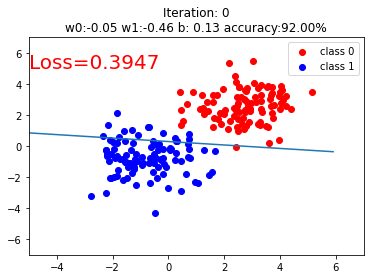

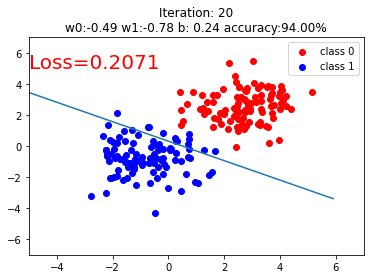

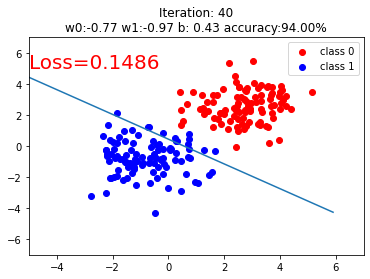

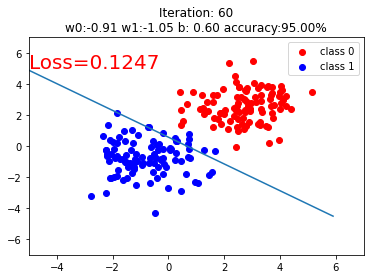

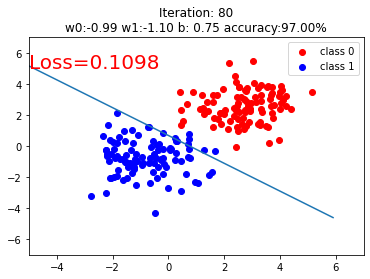

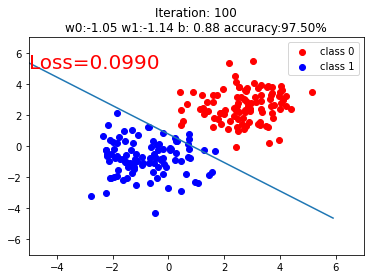

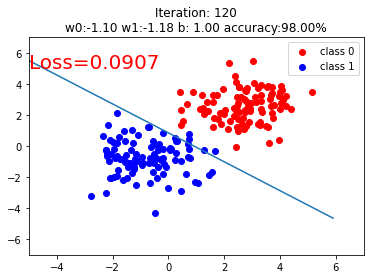

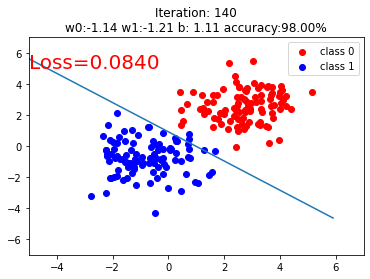

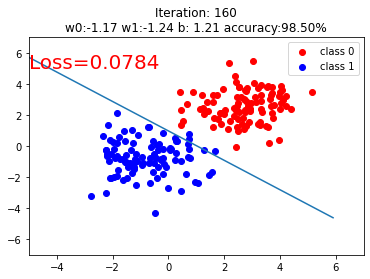

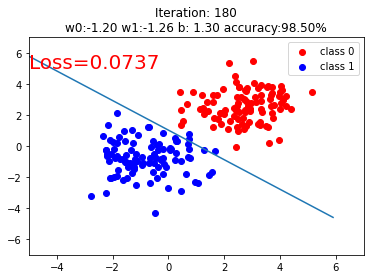

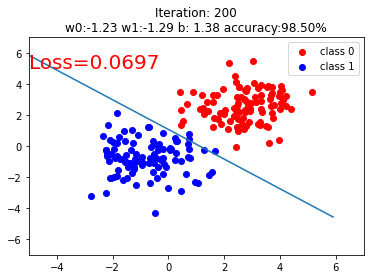

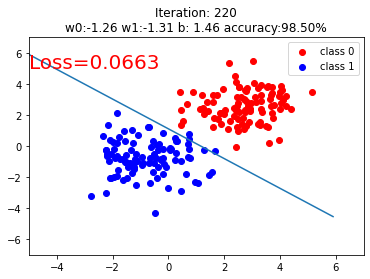

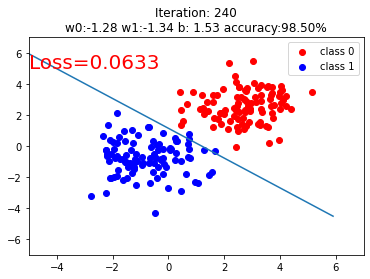

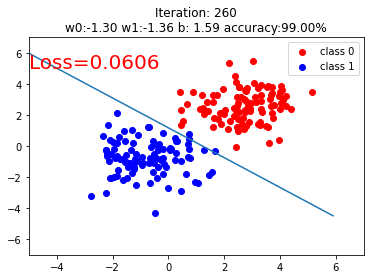

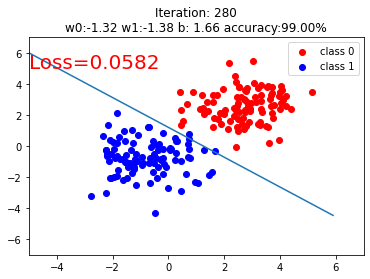

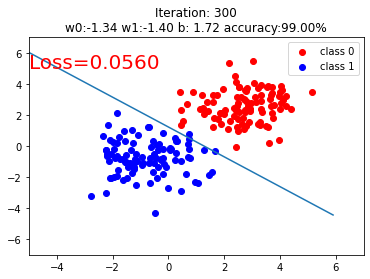

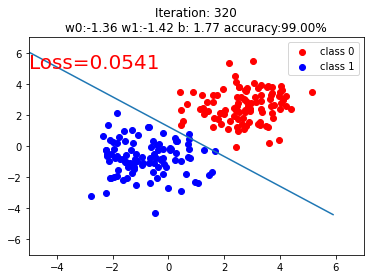

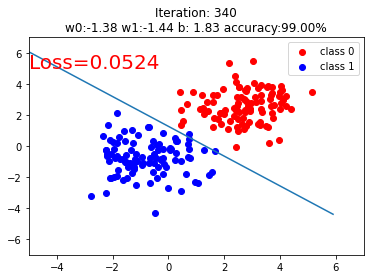

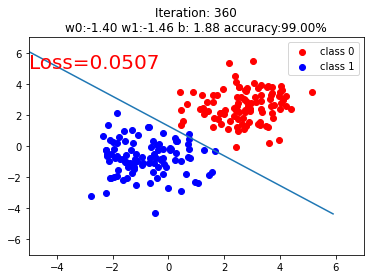

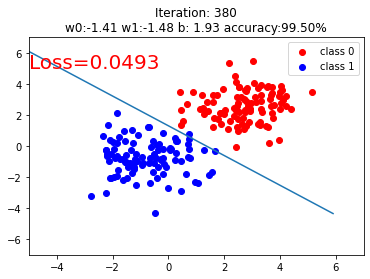

In [24]:
for iteration in range(1000):

    # 前向传播
    y_pred = lr_net(train_x)

    # 计算 loss
    loss = loss_fn(y_pred.squeeze(), train_y)

    # 反向传播
    loss.backward()

    # 更新参数
    optimizer.step()

    # 清空梯度
    optimizer.zero_grad()

    # 绘图
    if iteration % 20 == 0:

        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == train_y).sum()  # 计算正确预测的样本个数
        acc = correct.item() / train_y.size(0)  # 计算分类准确率

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
        plt.legend()

        plt.show()
        plt.pause(0.5)

        if acc > 0.99:
            break